In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import pickle
from nltk.tokenize import RegexpTokenizer
from scipy import sparse

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

## Uploading data

In [109]:
train = pd.read_csv(r'./disaster tweets/data/train.csv')
test = pd.read_csv(r'./disaster tweets/data/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [110]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<BarContainer object of 2 artists>

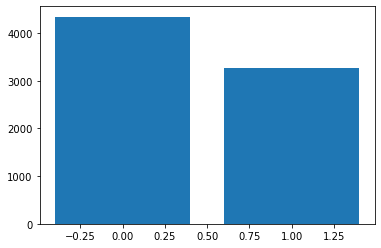

In [111]:
plt.bar(train['target'].value_counts().index, train['target'].value_counts().values)

### Analyzing 'keyword' and 'location' columns for missing values and outliers.

In [112]:
 train['location'].value_counts(dropna=False)

NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Miami Beach, Fl                    1
Escondido, CA                      1
Hustletown                         1
Huntley, IL                        1
Lancaster, Pennsylvania, USA       1
Name: location, Length: 3342, dtype: int64

**There are a lot of NaNs**

In [113]:
train_for_plot = train.fillna('NOINFO')
locations = train_for_plot['location'].value_counts(dropna=False)
freq_locations = list(locations.index)

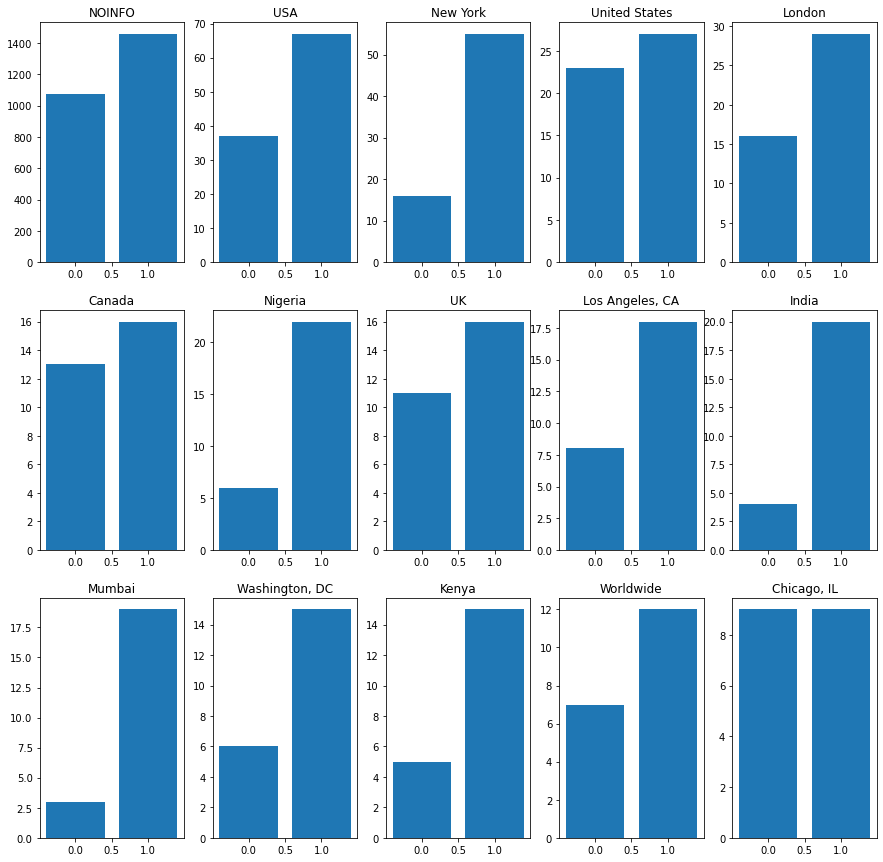

In [114]:
fig, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(3):
    for j in range(5):
        temp_data = train_for_plot[(train_for_plot['location'] == freq_locations[i*5 + j])]
        ax[i][j].set_title(freq_locations[i*5 + j])
        ax[i][j].bar([1, 0], temp_data['target'].value_counts().values)

In [115]:
frames = [train, test]
full_data = pd.concat(frames)

In [116]:
locs = full_data['location'].value_counts(dropna=True)

In [117]:
locations_nan = locs[locs > 8]
print(locations_nan.index)

Index(['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria',
       'India', 'Worldwide', 'Los Angeles, CA', 'UK', 'Kenya',
       'Washington, DC', 'Mumbai', 'United Kingdom', 'Australia', 'California',
       'Los Angeles', 'Chicago, IL', 'San Francisco', 'New York, NY', 'NYC',
       'California, USA', 'Florida', 'San Francisco, CA', 'Chicago', 'Toronto',
       'Washington, D.C.', 'Everywhere', 'Indonesia', 'Ireland', 'Seattle, WA',
       'ss', 'Seattle', 'Philippines', 'New York City', 'Atlanta, GA',
       'Singapore', 'London, UK', 'Manchester', 'Texas', 'Earth',
       'Denver, Colorado', 'London, England', 'Nashville, TN', 'World',
       'Denver, CO', 'Paterson, New Jersey ', '304', 'Dallas, TX',
       'Calgary, Alberta', 'San Diego, CA', 'Memphis, TN',
       'Melbourne, Australia', 'Pennsylvania, USA',
       ' Road to the Billionaires Club', 'Colorado', 'US', 'Houston, TX',
       'Sacramento, CA', '??????', 'Indiana', 'Global', 'Maryland',
       'Portland,

Replacing incorrect location names in test and train datasets

In [118]:
def change_location(dataset, name='dataset'):
    dataset['location'] = dataset['location'].replace('United States', 'USA')
    dataset['location'] = dataset['location'].replace('US', 'USA')
    dataset['location'] = dataset['location'].replace('Worldwide', 'Anywhere')
    dataset['location'] = dataset['location'].replace('worldwide', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Everywhere', 'Anywhere')
    dataset['location'] = dataset['location'].replace('California, USA', 'California')
    dataset['location'] = dataset['location'].replace('United Kingdom', 'UK')
    dataset['location'] = dataset['location'].replace('San Francisco, CA', 'San Francisco')
    dataset['location'] = dataset['location'].replace('Chicago, IL', 'Chicago')
    dataset['location'] = dataset['location'].replace('New York, NY', 'New York')
    dataset['location'] = dataset['location'].replace('Los Angeles, CA', 'Los Angeles')
    dataset['location'] = dataset['location'].replace('NYC', 'New York')
    dataset['location'] = dataset['location'].replace('New York City', 'New York')
    dataset['location'] = dataset['location'].replace('Earth', 'Anywhere')
    dataset['location'] = dataset['location'].replace('ss', 'Anywhere')
    dataset['location'] = dataset['location'].replace('304', 'Anywhere')
    dataset['location'] = dataset['location'].replace('World', 'Anywhere')
    dataset['location'] = dataset['location'].replace('??????', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Planet Earth', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Washington, D.C.', 'Washington, DC')
    dataset['location'] = dataset['location'].replace('Denver, Colorado', 'Denver')
    dataset['location'] = dataset['location'].replace('Denver, CO', 'Denver')
    dataset['location'] = dataset['location'].replace(' Road to the Billionaires Club', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Pennsylvania, USA', 'Pennsylvania')
    dataset['location'] = dataset['location'].replace('Paterson, New Jersey', 'Paterson')
    locations = dataset['location'].value_counts(dropna=True)
    anywhere_locations = locations[locations <= 8]
    for loc in list(anywhere_locations.index):
        dataset['location'] = dataset['location'].replace(loc, 'noinfo')
    dataset['location'].fillna('noinfo', inplace=True)
change_location(train, 'train')
change_location(test, 'test')
frames = [train, test]
full_data = pd.concat(frames)
print(full_data['location'].value_counts())

noinfo             9632
USA                 216
New York            165
Anywhere            138
UK                   59
Los Angeles          58
London               58
Washington, DC       47
California           46
San Francisco        43
Canada               42
Nigeria              40
Chicago              40
India                35
Kenya                32
Mumbai               22
Australia            18
Denver               16
Florida              14
Indonesia            13
Toronto              12
Pennsylvania         12
Ireland              12
Seattle              11
Atlanta, GA          10
London, UK           10
Sacramento, CA       10
London, England      10
Texas                10
Nashville, TN         9
Manchester            9
Dallas, TX            9
San Diego, CA         9
Philippines           9
Name: location, dtype: int64


In [119]:
keywords = train_for_plot['keyword'].value_counts(dropna=False)
keywords

NOINFO                   61
fatalities               45
armageddon               42
deluge                   42
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

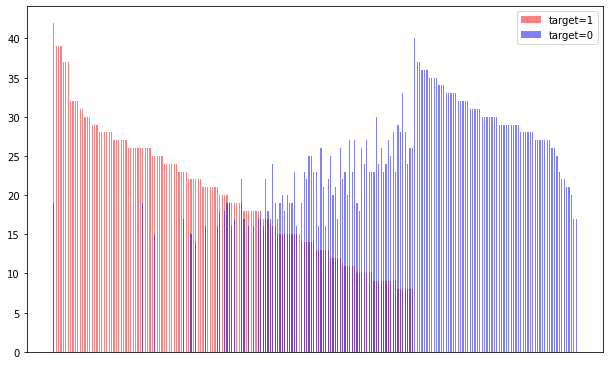

In [120]:
top = 150
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=90)
axes.get_xaxis().set_visible(False)
plt.bar(train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().values[:top],
        width=0.5, alpha=0.5, color='red', label='target=1')
plt.bar(train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().values[:top],
        width=0.5, alpha=0.5, color='blue', label='target=0')
plt.legend()

Top 40 keywords for each target value:

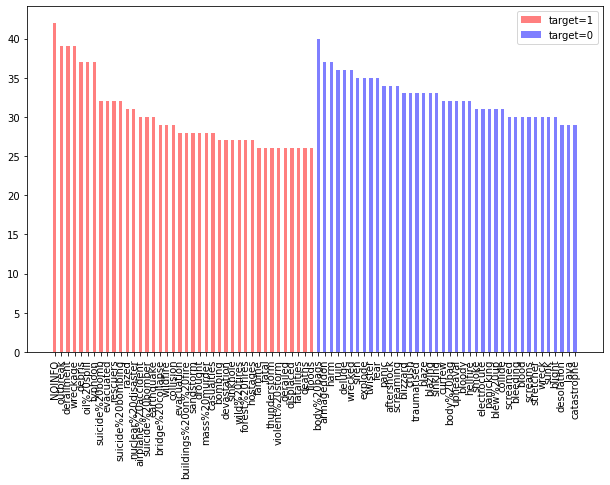

In [121]:
top = 40
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=90)
#axes.get_xaxis().set_visible(False)
plt.bar(train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().values[:top],
        width=0.5, alpha=0.5, color='red', label='target=1')
plt.bar(train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().values[:top],
        width=0.5, alpha=0.5, color='blue', label='target=0')
plt.legend()

150 most frequent keywords for each target value in different locations.

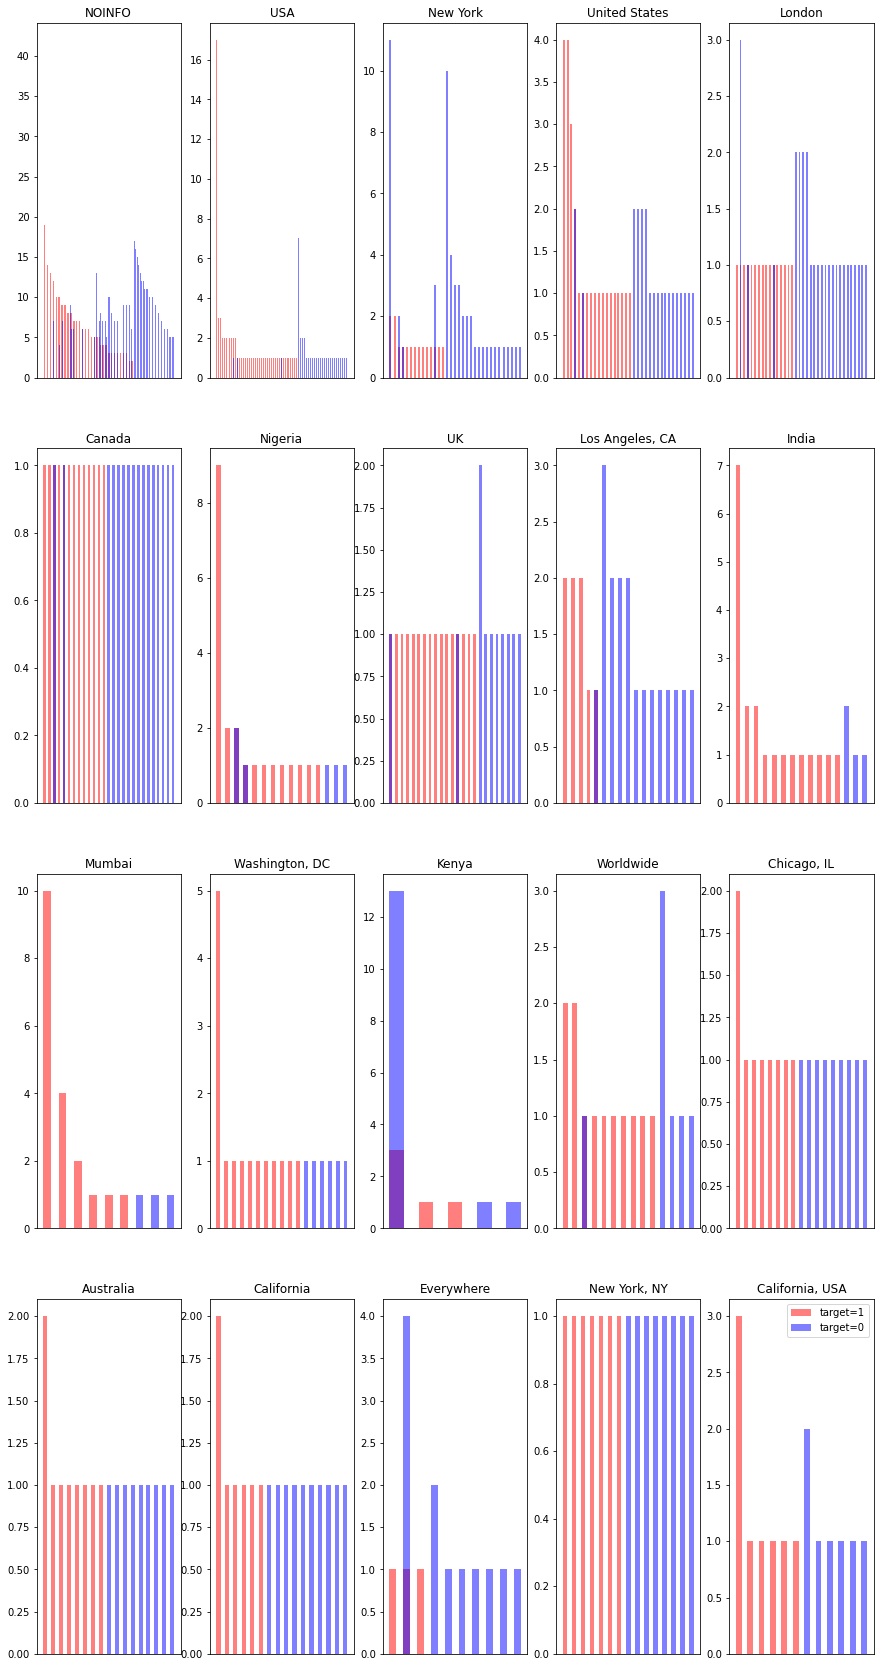

In [122]:
freq_locations = list(train_for_plot['location'].value_counts(dropna=False)[:20].index)
fig, axes = plt.subplots(4, 5, figsize=(15, 30))
top_keywords = 150
plt.xticks(rotation=90)
for ax, loc in zip(axes.reshape(-1), freq_locations):
    ax.set_title(loc)
    ax.get_xaxis().set_visible(False)
    ax.bar(train_for_plot[(train_for_plot['target'] == 1) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().index[:top_keywords],
        train_for_plot[(train_for_plot['target'] == 1) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().values[:top_keywords],
        width=0.5, alpha=0.5, color='red', label='target=1')
    ax.bar(train_for_plot[(train_for_plot['target'] == 0) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().index[:top_keywords],
        train_for_plot[(train_for_plot['target'] == 0) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().values[:top_keywords],
        width=0.5, alpha=0.5, color='blue', label='target=0')
plt.legend()

In [123]:
train['target'].value_counts()[1] / train['target'].value_counts()[0]

0.7533394748963611

## Simple linear models using two features

### Logistic Regression

In [124]:
np.random.seed(144)

train.fillna('noinfo', inplace=True)
test.fillna('noinfo', inplace=True)

shuffled_train = train.iloc[np.random.permutation(len(train))]

max_iter = 100
cv = 5

clf = LogisticRegressionCV(cv = cv, n_jobs = -1, max_iter = max_iter, scoring='f1')

X = shuffled_train[['location', 'keyword']]
Y = shuffled_train['target']
enc = OneHotEncoder()
X = enc.fit_transform(X)

clf.fit(X, Y)
print('Best mean score from 5 cross validations: ')
print(clf.scores_[1].mean(axis=0).max())

Best mean score from 5 cross validations: 
0.6725513461493352


### Bernoulli Naive Bayes

In [125]:
np.random.seed(144)

shuffled_train = train.iloc[np.random.permutation(len(train))]
clf = BernoulliNB(fit_prior = False)

X = shuffled_train[['location', 'keyword']]
Y = shuffled_train['target']
enc = OneHotEncoder()
X = enc.fit_transform(X)

score = cross_val_score(estimator=clf, X=X, y=Y, scoring='f1')

print('Best mean score from 5 cross validations: ')
print(score.mean())

Best mean score from 5 cross validations: 
0.6954745377661038


The results are not hight enough, so we'll use these them as baseline.

## Creating metafeatures from 'text' feature

### Text cleaning and transforming

**Lowercase**

In [126]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

**Removing links and mentions (@somebody)**

In [127]:
train['text'] = train['text'].apply(lambda x:
                                    re.sub(r'https?://\S+|www\.\S+','', x))
test['text'] = test['text'].apply(lambda x:
                                    re.sub(r'https?://\S+|www\.\S+','', x))

In [128]:
train['text'] = train['text'].apply(lambda x:
                                    re.sub(r'@[A-Za-z0-9]+','', x))
test['text'] = test['text'].apply(lambda x:
                                    re.sub(r'@[A-Za-z0-9]+','', x))
train['text'] = train['text'].apply(lambda x:
                                    re.sub(r'#','', x))
test['text'] = test['text'].apply(lambda x:
                                    re.sub(r'#','', x))

**Removing punctuation**

In [129]:
train['text'] = train['text'].apply(lambda x:
                                   re.sub(r'[^\w\s]','', x))
test['text'] = test['text'].apply(lambda x:
                                   re.sub(r'[^\w\s]','', x))

**Lemmatizing text**

In [130]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

train['text'] = train.text.apply(lambda x: lemmatize_text(x))
test['text'] = test.text.apply(lambda x: lemmatize_text(x))

**Stopwords analyze**

In [131]:
from nltk.corpus import stopwords
all_stopwords = set(stopwords.words('english'))

In [132]:
def stopword_count(data, column):
    count_dict = dict.fromkeys(all_stopwords, 0)
    def row_count(row):
        for word in row.split():
            if word in all_stopwords:
                count_dict[str(word)] += 1
    data[column].apply(lambda x: row_count(x))
    return count_dict

In [133]:
stopwords = stopword_count(train, 'text')
stopwords = pd.Series(stopwords, index=stopwords.keys())
stopwords = stopwords[stopwords > 0]
stopwords = stopwords.sort_values(ascending=False)

#### Most popular stopwords

<BarContainer object of 40 artists>

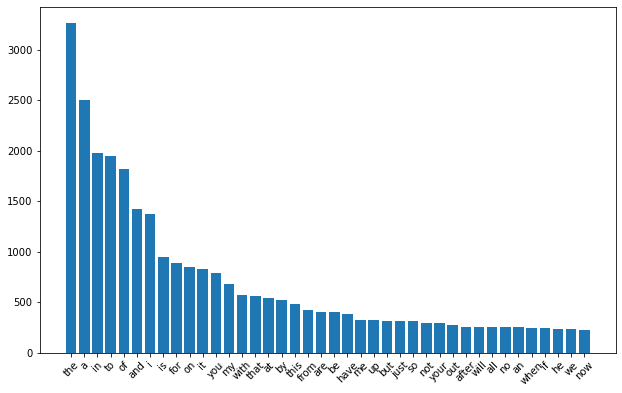

In [134]:
top = 40
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=45)
#axes.get_xaxis().set_visible(False)
plt.bar(stopwords[:top].index, stopwords[:top].values)

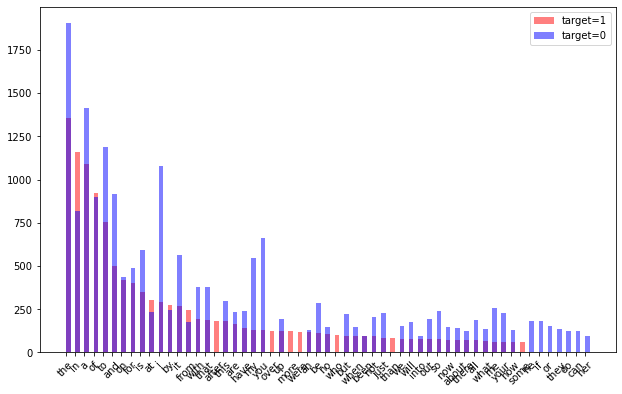

In [135]:
stopwords_1 = stopword_count(train[train['target'] == 1], 'text')
stopwords_1 = pd.Series(stopwords_1, index=stopwords.keys())
stopwords_1 = stopwords_1[stopwords_1 > 0]
stopwords_1 = stopwords_1.sort_values(ascending=False)
stopwords_0 = stopword_count(train[train['target'] == 0], 'text')
stopwords_0 = pd.Series(stopwords_0, index=stopwords.keys())
stopwords_0 = stopwords_0[stopwords_0 > 0]
stopwords_0 = stopwords_0.sort_values(ascending=False)

top = 50
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=45)
#axes.get_xaxis().set_visible(False)
axes.bar(stopwords_1[:top].index, stopwords_1[:top].values, 
        width=0.5, alpha=0.5, color='red', label='target=1', align='edge')
axes.bar(stopwords_0[:top].index, stopwords_0[:top].values, 
        width=0.5, alpha=0.5, color='blue', label='target=0', align='edge')
plt.legend()

**Removing stopwords**

In [136]:
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

**Removing words with numbers and letters along**

In [137]:
eng_words = set(nltk.corpus.words.words())
train['text'] = train['text'].apply(lambda x: ' '.join(w for w in x.split() if not any(j.isdigit() for j in w)))
test['text'] = test['text'].apply(lambda x: ' '.join(w for w in x.split() if not any(j.isdigit() for j in w)))

## TF-ID Vectorization

In [138]:
vect = CountVectorizer(min_df=3, ngram_range=(1,1))
enc = OneHotEncoder()

full_data = pd.concat((train, test))

enc.fit(full_data[['location', 'keyword']])
vect.fit(full_data['text'])
print(len(vect.get_feature_names()))
print(len(enc.get_feature_names()))

4833
256


## Methods using all features

### Random forest

In [139]:
np.random.seed(15)
shuffled_train = train.iloc[np.random.permutation(len(train))]
shuffled_test = test.iloc[np.random.permutation(len(test))]

n_estimators = [60, 80, 100]

X_vect = vect.transform(shuffled_train['text']).todense()
X_onehot = enc.transform(shuffled_train[['location', 'keyword']]).todense()
X = np.concatenate((X_vect, X_onehot), axis=1)
Y = shuffled_train['target']

for n_est in n_estimators:
    clf = RandomForestClassifier(n_estimators=n_est, max_features='sqrt', verbose=0, n_jobs=-1)
    score = cross_val_score(estimator=clf, X=X, y=Y, scoring='f1', cv=3)
    print('f1 scores from 3 validations')
    print(score)
    print('\n')

f1 scores from 3 validations
[0.72089625 0.73140097 0.74681754]


f1 scores from 3 validations
[0.72254902 0.73653566 0.75460993]


f1 scores from 3 validations
[0.72941176 0.73314066 0.7432878 ]




### Bernoulli Naive Bayes

In [140]:
vect = TfidfVectorizer(min_df=3, ngram_range=(1,1))
enc = OneHotEncoder()

full_data = pd.concat((train, test))

enc.fit(full_data[['location', 'keyword']])
vect.fit(full_data['text'])
print(len(vect.get_feature_names()))
print(len(enc.get_feature_names()))

4833
256


In [141]:
np.random.seed(15)

shuffled_train = train.iloc[np.random.permutation(len(train))]
clf = BernoulliNB(fit_prior = False)

X_vect = vect.transform(shuffled_train['text']).todense()
X_onehot = enc.transform(shuffled_train[['location', 'keyword']]).todense()
X = np.concatenate((X_vect, X_onehot), axis=1)
Y = shuffled_train['target']

X_sparsed = sparse.csr_matrix(X)

score = cross_val_score(estimator=clf, X=X_sparsed, y=Y, scoring='f1', cv=5)

print('Best scores from 3 cross validations: ')
print(score)

Best scores from 3 cross validations: 
[0.75609756 0.76121795 0.76190476 0.75701684 0.77505919]


### Logistic Regression

In [142]:
np.random.seed(15)
shuffled_train = train.iloc[np.random.permutation(len(train))]
shuffled_test = test.iloc[np.random.permutation(len(test))]

max_iter = 400

X_vect = vect.transform(shuffled_train['text']).todense()
X_onehot = enc.transform(shuffled_train[['location', 'keyword']]).todense()
X = np.concatenate((X_vect, X_onehot), axis=1)
Y = shuffled_train['target']

X_sparsed = sparse.csr_matrix(X)

clf = LogisticRegressionCV(n_jobs = -1, max_iter = max_iter, scoring='f1')
score = cross_val_score(estimator=clf, X=X_sparsed, y=Y, scoring='f1', cv=5)
print('scores from 5 cross validations: ')
print(score)
print('\n')

scores from 5 cross validations: 
[0.74840764 0.74979491 0.74478331 0.74879227 0.77308294]




### Support Vector Machine

In [143]:
np.random.seed(15)
shuffled_train = train.iloc[np.random.permutation(len(train))]
shuffled_test = test.iloc[np.random.permutation(len(test))]

max_iter = 70000

X_vect = vect.transform(shuffled_train['text']).todense()
X_onehot = enc.transform(shuffled_train[['location', 'keyword']]).todense()
X = np.concatenate((X_vect, X_onehot), axis=1)
Y = shuffled_train['target']

X_sparsed = sparse.csr_matrix(X)

kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:
    clf = SVC(max_iter = max_iter, kernel=kernel)
    score = cross_val_score(estimator=clf, X=X_sparsed, y=Y, scoring='f1', cv=5)
    print(kernel)
    print(score)
    print('\n')

linear
[0.73067535 0.75164474 0.75183076 0.74818986 0.77409163]


rbf
[0.72058824 0.72560467 0.72981878 0.71654198 0.7483871 ]


poly
[0.70940883 0.71355932 0.71475954 0.7061812  0.73505654]




## Making predictions

In [144]:
from datetime import datetime

We'll use an ensamble of LogRegression, Naive Bayes, SVM(linear kernel) and Random Forest

### Vectorization

In [145]:
vect = CountVectorizer(min_df=3, ngram_range=(1,1))
enc = OneHotEncoder()

full_data = pd.concat((train, test))

enc.fit(full_data[['location', 'keyword']])
vect.fit(full_data['text'])
print(len(vect.get_feature_names()))
print(len(enc.get_feature_names()))

4833
256


### LogRegression

In [146]:
max_iter = 400

X_vect_train = vect.transform(train['text']).todense()
X_onehot_train = enc.transform(train[['location', 'keyword']]).todense()
X_train = np.concatenate((X_vect_train, X_onehot_train), axis=1)
Y_train = train['target']

X_vect_test = vect.transform(test['text']).todense()
X_onehot_test = enc.transform(test[['location', 'keyword']]).todense()
X_test = np.concatenate((X_vect_test, X_onehot_test), axis=1)

X_vect_train

start = datetime.now()

clf = LogisticRegressionCV(n_jobs = -1, max_iter = max_iter, scoring='f1')
clf.fit(X_sparsed_train, Y_train)

print('Training time')
print(datetime.now() - start)

start = datetime.now()
LogReg_predict = clf.predict_proba(X_sparsed_test)
LogReg_predict = LogReg_predict[:, 1]

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:04.292173
Predicting time
0:00:00.004986


### Bernoulli Naive Bayes

In [147]:
X_vect_train = vect.transform(train['text']).todense()
X_onehot_train = enc.transform(train[['location', 'keyword']]).todense()
X_train = np.concatenate((X_vect_train, X_onehot_train), axis=1)
Y_train = train['target']

X_vect_test = vect.transform(test['text']).todense()
X_onehot_test = enc.transform(test[['location', 'keyword']]).todense()
X_test = np.concatenate((X_vect_test, X_onehot_test), axis=1)

X_sparsed_train = sparse.csr_matrix(X_train)
X_sparsed_test = sparse.csr_matrix(X_test)

start = datetime.now()

clf = BernoulliNB(fit_prior = False)
clf.fit(X_sparsed_train, Y_train)

print('Training time')
print(datetime.now() - start)

start = datetime.now()

NaiveBayes_predict = clf.predict_proba(X_sparsed_test)
NaiveBayes_predict = NaiveBayes_predict[:, 1]

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:00.004924
Predicting time
0:00:00.006981


### Support Vector Machine

In [148]:
max_iter = 70000

X_vect_train = vect.transform(train['text']).todense()
X_onehot_train = enc.transform(train[['location', 'keyword']]).todense()
X_train = np.concatenate((X_vect_train, X_onehot_train), axis=1)
Y_train = train['target']

X_vect_test = vect.transform(test['text']).todense()
X_onehot_test = enc.transform(test[['location', 'keyword']]).todense()
X_test = np.concatenate((X_vect_test, X_onehot_test), axis=1)

X_sparsed_train = sparse.csr_matrix(X_train)
X_sparsed_test = sparse.csr_matrix(X_test)

start = datetime.now()

clf = SVC(max_iter = max_iter, kernel='linear')
clf.fit(X_sparsed_train, Y_train)

print('Training time')
print(datetime.now() - start)

start = datetime.now()

SVM_predict = clf.predict(X_sparsed_test)

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:04.973881
Predicting time
0:00:01.042240


Can't interpret SVM results as probability, so we'll not use it in ensamble.

### Random Forest

In [149]:
max_iter = 150

X_vect_train = vect.transform(train['text']).todense()
X_onehot_train = enc.transform(train[['location', 'keyword']]).todense()
X_train = np.concatenate((X_vect_train, X_onehot_train), axis=1)
Y_train = train['target']

X_vect_test = vect.transform(test['text']).todense()
X_onehot_test = enc.transform(test[['location', 'keyword']]).todense()
X_test = np.concatenate((X_vect_test, X_onehot_test), axis=1)

start = datetime.now()

clf = RandomForestClassifier(n_estimators=max_iter, max_features='sqrt', verbose=0, n_jobs=-1)
clf.fit(X_train, Y_train)

print('Training time')
print(datetime.now() - start)

start = datetime.now()

RF_predict = clf.predict_proba(X_test)
RF_predict = RF_predict[:, 1]

print('Predicting time')
print(datetime.now() - start)

Training time
0:01:07.174144
Predicting time
0:00:00.495674


### Mean prediction from 3 models

In [150]:
predict = (LogReg_predict + NaiveBayes_predict + RF_predict) / 3

In [151]:
predict[predict >= 0.5] = int(1)
predict[predict < 0.5] = int(0)

In [152]:
result_df = pd.DataFrame(test['id'].values, columns=['id']) 
result_df['target'] = predict.astype(int)
result_df.to_csv(path_or_buf=r'./disaster tweets/submission_Ensamble.csv', index=False)

In [153]:
for name, predict in [('LogReg', LogReg_predict),
                      ('NaiveBayes', NaiveBayes_predict), ('RF', RF_predict), ('SVM', SVM_predict)]:
    predict[predict >= 0.5] = int(1)
    predict[predict < 0.5] = int(0)
    result_df = pd.DataFrame(test['id'].values, columns=['id']) 
    result_df['target'] = predict.astype(int)
    result_df.to_csv(path_or_buf=r'./disaster tweets/submission_' + name + '.csv', index=False)

**Saving trained models without using 'location' and 'keyword' features for future using**

In [154]:
X_sparsed_train = sparse.csr_matrix(X_vect_train)

In [155]:
max_iter = 400
clf_LogReg = LogisticRegressionCV(n_jobs = -1, max_iter = max_iter, scoring='f1')
clf_LogReg.fit(X_sparsed_train, Y_train)

max_iter = 150
clf_RF = RandomForestClassifier(n_estimators=max_iter, max_features='sqrt', verbose=0, n_jobs=-1)
clf_RF.fit(X_sparsed_train, Y_train)

clf_NB = BernoulliNB(fit_prior = False)
clf_NB.fit(X_sparsed_train, Y_train)

BernoulliNB(fit_prior=False)

In [156]:
pickle.dump(clf_LogReg, open(r'disaster tweets/models/LogReg_model.sav', 'wb'))
pickle.dump(clf_RF, open(r'disaster tweets/models/RF_model.sav', 'wb'))
pickle.dump(clf_NB, open(r'disaster tweets/models/NB_model.sav', 'wb'))
pickle.dump(vect, open(r'disaster tweets/models/vectorizer.sav', 'wb'))